In [2]:
import sys
sys.path.append('./libs')

import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from osgeo import gdal
from timeit import default_timer as timer
from skimage import img_as_ubyte
from termcolor import colored
from keras.models import load_model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import joblib
import gc

import warnings
warnings.simplefilter("ignore")

In [3]:
import inspecao_frames as buscaice_frames
import geraIcebergsDB as gIDB
import training as fTrein
import myGeoTools as mgt
import getClassification as goclass
import transfDimensionalidade as tdim
from myutils import imresize, convert_bytes, fix_coast, convert, match_hist
from IPython.display import clear_output # progressbar
%matplotlib inline

In [4]:
# SAR IMPUT
arquivo_path = './SAR/'
image_name = 'RAMP_1997.tif'

## Global Flags

In [5]:
gdal.UseExceptions()
sfull = timer()

## FLAGS ###########################################################################
# Create IcebergDB - This Flag only enables classify to purpose of save iceberg and non iceberg picks
geraDBIce = False

# Save or load training models
saveTreino = True

loadTreino = True if not saveTreino else False

# Enable training set backfeed
backfeed = False

# Export products
is2export = False

## Start process
### Open geotiff data
### Get geo-information
### Prepare data-structures

Data:  RAMP_1997.tif
Pixel size:  100 m
Scene Bounds:  {'UL': [-107.17611506659654, -72.79683313653425], 'LL': [-113.74757308374667, -72.05521668606751], 'UR': [-110.19955459349559, -75.25850789074228], 'LR': [-117.64059156721962, -74.39295049019628]}
SAR INPUT: RAMP_1997.tif


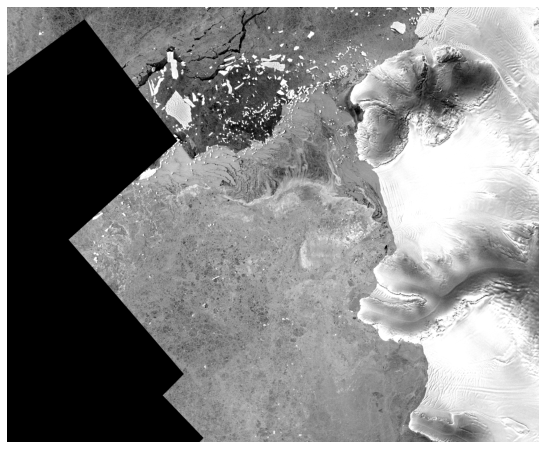

In [6]:
## START PROCESSING ###########################################################
global img
cont_removidas = 0

f_name, f_ext = image_name.split('.')

plt.clf()
plt.close("all")

print(colored('Data: ', 'blue'), image_name)

#Depends on the dataset used... got directly from the label
data_img = image_name[14:22]
ano_img = image_name[14:18]

gtiff = arquivo_path + image_name

ds = gdal.Open(gtiff)
img = np.asarray(ds.GetRasterBand(1).ReadAsArray())
img = img_as_ubyte(img)

rowsb, colsb = img.shape
# Getting scene bounds
gt = ds.GetGeoTransform()

colunas = ds.RasterXSize
linhas = ds.RasterYSize
# bandas = ds.RasterCount

mask = pickle.load(open("./AuxFiles/mask.pkl", "rb"))
mask_gt = pickle.load(open("./AuxFiles/mask_gt.pkl", "rb"))

# Pixel size (m)
pixel_size = round(gt[1])
print(colored("Pixel size: ", "blue"), pixel_size, 'm')

#Area by pixel (m^2)
pixel_area = pixel_size**2

# Getting scene bounds as lat lon (pixel2coord(lon, lat))
x1, y1 = mgt.pixel2coord(ds, 0, 0)
x2, y2 = mgt.pixel2coord(ds, 0, linhas-1)
x3, y3 = mgt.pixel2coord(ds, colunas-1, 0)
x4, y4 = mgt.pixel2coord(ds, colunas-1, linhas-1)

## Working land mask based on shape files
mask_crop = mgt.crop_image(mask_gt, mask, x1, y1, x3, y2)
maskl, maskc = mask_crop.shape
del mask

#Tranforming EPS3031 coordinates system to WGS84
x1, y1 = mgt.epsg3031toepsg4326(x1, y1)  # Corner (ULX,ULY)
x2, y2 = mgt.epsg3031toepsg4326(x2, y2)  # Corner (LLX,LLY)
x3, y3 = mgt.epsg3031toepsg4326(x3, y3)  # Corner (URX,URY)
x4, y4 = mgt.epsg3031toepsg4326(x4, y4)  # Corner (LRX,LRY)

corners_wgs84 = {'UL': [x1, y1], 'LL': [x2, y2], 'UR': [x3, y3], 'LR': [x4, y4]}

if (maskc == 0 or maskl == 0):
    # os.remove(gtiff)
    cont_removidas += 1

lin, col = img.shape
mask_crop = imresize(mask_crop, (lin, col))

##Fixing nearest costal problem and getting masks info
land_pixels, area_pixels = fix_coast(mask_crop, img)

scene_info = {'image_name': image_name, 'file_path': arquivo_path, 'rows': linhas, 'colums': colunas,
              'year': ano_img, 'date_img': data_img, 'ds': ds, 'pixel_size': pixel_size,'pixel_area': pixel_area,
              'land_pixels': land_pixels, 'area_pixels': area_pixels, 'corners_wgs': corners_wgs84}

print(colored("Scene Bounds: ", "blue"), corners_wgs84)

del linhas, colunas, ano_img
del data_img, ds, pixel_size, pixel_area, land_pixels
del area_pixels, corners_wgs84

del mask_crop
gc.collect()
print('SAR INPUT: '+image_name)

plt.figure('SAR INPUT', figsize=(10, 8))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Land Masking

Masking Land pixels...
Done!  0.0  min
SAR NO LAND


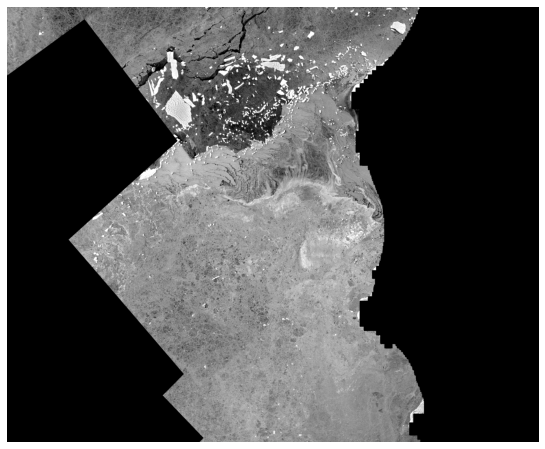

In [7]:
## Preprocessing ########################################################################
s = timer()
print(colored('Masking Land pixels...', 'blue'))
# Removing land Pixels
img[scene_info['land_pixels'][0], scene_info['land_pixels'][1]] = 0
e = timer()
print('Done! ', round((e-s)/60, 3), ' min')
gc.collect()
print('SAR NO LAND')

plt.figure('SAR NO LAND', figsize=(10, 8))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Segmentation in 2 levels
### Superpixel Graph-based Felzenwalb for large objects with high intensity/texture variation over the object surface
### Watershed for small objects

Segmenting ...
Pre-processing for segmentation, histogram score 0.895 of 1.0
Computing objects.
Felzemwalb Segmentation for giants


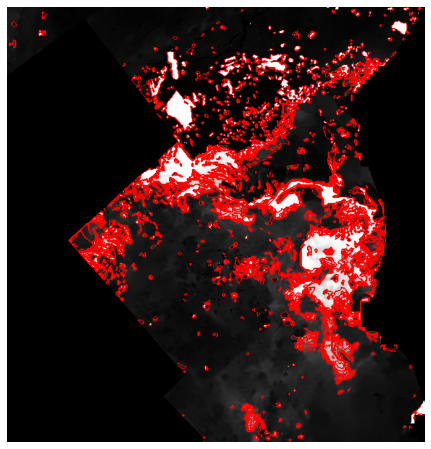

Computing segmentation metadata...
Pre-processing for segmentation, histogram score 0.893 of 1.0
Computing objects.
Watershed Segmentation for no giants


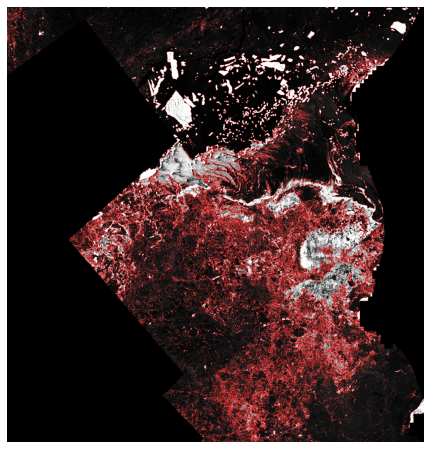

Computing segmentation metadata...
Done!  1.182  min
Total Objects for classification:  2612


In [8]:
## Segmentation and Morphologycal infos extraction ####################################################
# Using 2 stages segmentations 1 for giant icebergs and other for no giant
print(colored('Segmenting ...', 'blue'))
s = timer()
sub_giant = 30
segOutput = buscaice_frames.buscaIce(np.copy(img), rsp=sub_giant, alg=1, minseg=10001, maxseg=np.inf)
segOutput2 = buscaice_frames.buscaIce(np.copy(img), rsp=100, alg=2, minseg=10, maxseg=10000)
e = timer()
print('Done! ', round((e - s) / 60, 3), ' min')

print(colored('Total Objects for classification: ', 'blue'), len(segOutput2.idf)+len(segOutput.idf))

## Export segments from segmentation (no-classified)

In [9]:
## Set Icebergs e Features database ###################################################################
path_IDB = scene_info['file_path'] + 'db/'
if geraDBIce:
    gIDB.geraIceDB(path_IDB, np.copy(img), scene_info['image_name'], segOutput)

## Training stage
### Is possible to load or save as pkl

In [10]:
## Training supervised classifiers ###################################################################
if loadTreino:

    shape_rf = joblib.load('./models/ens_5.pkl')
    deep_mlp = load_model('./models/modeldeep_mlp.h5')

    print(colored('Models Loaded.', 'blue'))

else:
        
    print(colored('Training ...', 'blue'))
    
    DB_name_1 = pd.read_csv('./models/TrainSet_FULL.txt', sep=' ', header=None)
    DB_name_2 = pd.read_csv('./models/TrainSet_DEEP.txt', sep=' ', header=None)
    
    shape_rf = fTrein.settreino_ForestComite(DB_name_1)
    deep_mlp = fTrein.set_deeplearning(DB_name_2)

    if saveTreino:
        joblib.dump(shape_rf, './models/ens_5.pkl')
        deep_mlp.save('./models/modeldeep_mlp.h5')
        
        print(colored('Models Saved.', 'blue'))

committee = [shape_rf, deep_mlp]
del shape_rf, deep_mlp

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Models Loaded.


## Classification
### Looking for large objects from segmentation 1

In [11]:
ices_df = pd.DataFrame(columns=('date', 'latitude', 'longitude', 'minoraxis_px', 
                                'majoraxis_px', 'area_px', 'perimeter_px', 'shape'))

total_detected = 0
nicebergs, img_resultg, ices_df = goclass.goClassification(segOutput,ices_df, imresize(img, (sub_giant/100.0), interp='bilinear'),
                                                  committee, scene_info, img_result=[], backfeed=backfeed, 
                                                  fullplot=False, sub_giant=sub_giant)

total_detected += nicebergs
print(colored('Total classified from stage 1: ', 'blue'), total_detected)

Classification Progress: [##################################################] 100.0% (100.0)% detected icebergs: 1
Computing metadata ...
Total classified from stage 1:  1


## Classification
### Looking for small objects from segmentation 2

Classification Progress: [##################################################] 100.0% (100.0)% detected icebergs: 588
Computing metadata ...
SAR Base to Classification.


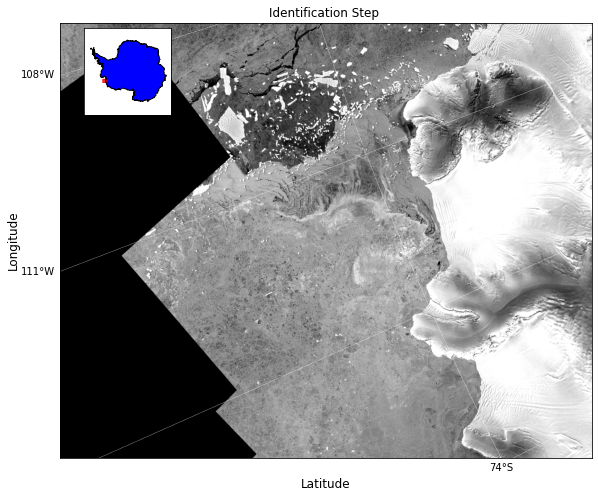

Classification product.


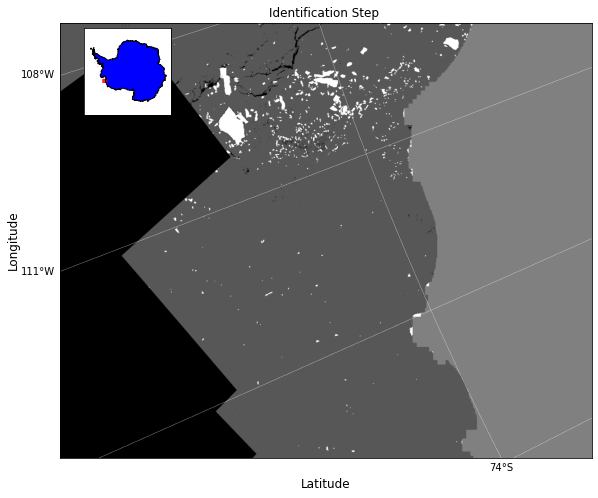

Total Icebergs detected:  589
Process complete ... 6.946  min


In [12]:
gc.collect()
print('Looking for NO giant icebergs')
img_result = np.zeros((rowsb, colsb))
img_result[scene_info['area_pixels']] = 75
img_result[scene_info['land_pixels'][0], scene_info['land_pixels'][1]] = 110

if total_detected > 0:
    img_resultg = imresize(img_resultg, (rowsb, colsb))
    img_result[img_resultg != 0] = img_resultg[img_resultg != 0]
    del img_resultg

nicebergs, img_result, ices_df = goclass.goClassification(segOutput2,ices_df, np.copy(img), committee, scene_info,
                                                          img_result=img_result, backfeed=backfeed, fullplot=True,
                                                          plot_original=True, save_identify=is2export)

total_detected += nicebergs

print(colored('Total Icebergs detected: ', 'blue'), total_detected)

efull = timer()
print(colored('Process complete ...', 'blue'), round((efull - sfull) / 60, 3), ' min')

## Analisys
### Metadata from Classification

In [13]:
print('Icebergs metadata')
ices_df.head()

Icebergs metadata


,date,latitude,longitude,minoraxis_px,majoraxis_px,area_px,perimeter_px,shape
0,,-73.437216,-109.726153,133,193,18466,843,"[77, 79, 80, 80, 80, 80, 80, 80, 90, 101, 102,..."
1,,-73.267702,-107.685645,3,4,11,9,"[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
2,,-73.722877,-108.211019,9,18,111,46,"[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."
3,,-74.280930,-108.883098,3,14,34,25,"[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
4,,-74.320507,-108.950846,13,19,186,53,"[7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."


In [14]:
ices_df['minoraxis_km'] = (ices_df['minoraxis_px'] * scene_info['pixel_size']) * 1e-3
ices_df['majoraxis_km'] = (ices_df['majoraxis_px'] * scene_info['pixel_size']) * 1e-3
ices_df['perimeter_km'] = (ices_df['perimeter_px'] * scene_info['pixel_size']) * 1e-3
ices_df['area_km2'] = (ices_df['area_px'] * (scene_info['pixel_size']**2)) * 1e-6
ices_df['mass_gt'] = (((ices_df['area_km2'] * 1e6) * 250) * 850) * 1e-12

iceberg_metadata = pd.concat([ices_df.loc[:, 'date':'longitude'], ices_df.loc[:, 'minoraxis_km':'mass_gt']], axis=1)
iceberg_metadata.head()

,date,latitude,longitude,minoraxis_km,majoraxis_km,perimeter_km,area_km2,mass_gt
0,,-73.437216,-109.726153,13.3,19.3,84.3,184.66,39.2402
1,,-73.267702,-107.685645,0.3,0.4,0.9,0.11,0.023375
2,,-73.722877,-108.211019,0.9,1.8,4.6,1.11,0.235875
3,,-74.280930,-108.883098,0.3,1.4,2.5,0.34,0.07225
4,,-74.320507,-108.950846,1.3,1.9,5.3,1.86,0.39525
